In [15]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler

import os

from tqdm.auto import tqdm

import shutil

from itertools import groupby

import matplotlib.pyplot as plt

from statistics import mean

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy import signal

import tensorflow as tf
from tensorflow import keras

import pickle

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d

tqdm.pandas()

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# path of original data folder
data_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data"
# path of csv files, each file is a 2mins walk for a subject
csvD_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/csv_files"
# In this file, the Null values are replaved with 0 in the HY scale - Null values were given to healthy control
demographics = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/Processed_data/demographics_HYprocessed.csv" 
dem_df = pd.read_csv(demographics)
# parequet folder path
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"

In [18]:
class Data:
  def __init__(self, prepare_or_get, data_folder, demographics_file, parquet_path):
    '''
    :param prepare_or_get:  1: prepare data , 0: load preloaded datas (npy)
    :param data_folder: path for a folder containing csv files, file for each 2 mins walk (for indivdiual subject)
    :param demographics_file: path for csv demographics file
    :save_path: path where to save/read parquet files after preparing them
    :
    '''

    self.data_path = data_folder
    self.parquet_path= parquet_path
    self.dem_path= demographics_file
    self.scale="HoehnYahr"            # fixed for now
    self.seconds_to_discard = 20      # fixed for now
    self.rows_to_discard = 100 * self.seconds_to_discard
    self.cols_names = ['Time', 'L1' , 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 
            'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 
            'Total_Force_Left', 'Total_Force_Right']

    # data in arrays
    self.signals_data = []
    self.cycles_data=[]
    self.statical_data=[]
    self.raw_statics=[]
    self.stances=[]
  
    # data in df
    self.signals_data_df= None
    self.cycles_data_df= None
    self.statical_data_df=None
    self.left_stances_df=None
    self.right_stances_df=None
    self.raw_statics_df=None
    self.stances_all_sensors_df=None
    self.scaled_right_stances=None
    self.scaled_left_stances=None
    self.scaled_stances_all_sensors_df=None
    self.scaled_stances_statics_df=None

    # calling the corresponding function as the 
    if (prepare_or_get==1):
      self.prepare_data()
    elif (prepare_or_get==0):
      self.get_data()
  
  def get_data(self):
    self.signals_data_df= pd.read_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df=pd.read_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df=pd.read_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df=pd.read_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df=pd.read_parquet(self.parquet_path+'right_stances.gzip')
    self.raw_statics_df=pd.read_parquet(self.parquet_path+'raw_statics.gzip')
    self.stances_all_sensors_df=pd.read_parquet(self.parquet_path+'stances_all_sensors.gzip')
    self.scaled_right_stances=pd.read_parquet(self.parquet_path+'scaled_right_stances.gzip')
    self.scaled_left_stances=pd.read_parquet(self.parquet_path+'scaled_left_stances.gzip')
    self.scaled_stances_all_sensors_df=pd.read_parquet(self.parquet_path+'scaled_all_sensors_stances.gzip')
    self.scaled_stances_statics_df=pd.read_parquet(self.parquet_path+'scaled_stances_statics.gzip')

  def prepare_data(self):
    self.scaled_stances_all_sensors_df=pd.read_parquet(parquet_path+'scaled_all_sensors_stances.gzip')
    # loop over files, each file is a 2 min walk for a single individual
    # files are expected to be in csv format
    self.dem_df = pd.read_csv(self.dem_path)
    for name in tqdm((os.listdir(self.data_path))):
       
      # id of subject
      id = name.split('_')[0]

      # disease level according to 'self.scale'
      level = self.get_pd_level( id)

      # parkinon's patient OR healthy control ?
      if 'Co' in name:  
        parkinson = 0 # Healthy control
      elif 'Pt' in name:
        parkinson = 1 # Parkinson's Patient

      # read and filter one file
      one_walk=self.read_filter(name)

      # sum of values from all the left sensors
      one_walk['Total_Force_Left'] = one_walk[list(one_walk.columns[0:8])].sum(axis=1)
     
      # sum of values from all the right sensors
      one_walk['Total_Force_Right'] = one_walk[list(one_walk.columns[8:16])].sum(axis=1)
      
      # convert to lists
      one_walk_lists=[]*18
      for column in one_walk.columns.values.tolist():
        one_walk_lists.append(one_walk[column].tolist()) 
      
      # print(one_walk_lists)

      # Raw statics
      raw_statics_1 = self.get_statics_raw_siganls(one_walk)
      
      ## Left foot related ##
      l_stances, l_strides_time , l_swings_time, l_stances_time, l_indices = self.segment_signal(one_walk_lists[16])
      # stances from all sensors underneath left foot
      # NOTE the (l_indices) are for gait not stance cycles, so here the results are gait cycles not stances
      L1_stances , L2_stances, L3_stances, L4_stances, L5_stances, L6_stances, L7_stances, L8_stances =  self.get_foot_gait_cycles(l_indices,one_walk_lists, "l")
      # Find maximum VGRF at heel strike for each gait cycle 
      l_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[0],l_indices) # sensor 0 = left heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      l_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[7],l_indices) # sensor 7 = left toe sensor
      # Equalising Segmented Signals
      l_stances, l_strides_time , l_swings_time, l_stances_time, l_peaks_toe, l_peaks_heel = self.equal_cycles(l_stances, l_strides_time , l_swings_time, l_stances_time, l_peaks_toe, l_peaks_heel)
      

      ## right foot related ##
      r_stances, r_strides_time , r_swings_time, r_stances_time, r_indices = self.segment_signal(one_walk_lists[17])
      # stances from all sensors underneath left foot
      # NOTE the (r_indices) are for gait not stance cycles, so here the results are gait cycles not stances
      R1_stances , R2_stances, R3_stances, R4_stances, R5_stances, R6_stances, R7_stances, R8_stances =  self.get_foot_gait_cycles(r_indices,one_walk_lists, "r")
      # Find maximum VGRF at heel strike for each gait cycle 
      r_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[8],l_indices) # sensor 8 = right heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      r_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[15],l_indices) # sensor 15 = right toe sensor
      # Equalising Segmented Signals
      r_stances, r_strides_time , r_swings_time, r_stances_time, r_peaks_toe, r_peaks_heel = self.equal_cycles(r_stances, r_strides_time , r_swings_time, r_stances_time, r_peaks_toe, r_peaks_heel)
      
      ## For both Foot ##
      b_r_stances, b_r_strides_time , b_r_swings_time, b_r_stances_time, b_r_peaks_toe, b_r_peaks_heel ,\
      b_l_stances, b_l_strides_time , b_l_swings_time, b_l_stances_time, b_l_peaks_toe, b_l_peaks_heel ,\
      b_R1_stances , b_R2_stances, b_R3_stances, b_R4_stances, b_R5_stances, b_R6_stances, b_R7_stances, b_R8_stances,\
      b_L1_stances , b_L2_stances, b_L3_stances, b_L4_stances, b_L5_stances, b_L6_stances, b_L7_stances, b_L8_stances=\
      self.equal_cycles(r_stances, r_strides_time , r_swings_time, r_stances_time, r_peaks_toe, r_peaks_heel,\
                          l_stances, l_strides_time , l_swings_time, l_stances_time, l_peaks_toe, l_peaks_heel,\
                          R1_stances , R2_stances, R3_stances, R4_stances, R5_stances, R6_stances, R7_stances, R8_stances,\
                          L1_stances , L2_stances, L3_stances, L4_stances, L5_stances, L6_stances, L7_stances, L8_stances)
    
      ## Saving data ##
      # Raw Signals
      self.signals_data.append([id,level,parkinson] +one_walk_lists)
      
      # Raw Statics
      self.raw_statics.append([id,level,parkinson] +raw_statics_1)
      
      # Statical
      self.statical_data.append( [ id, level, parkinson 
                                , mean (l_swings_time) , np.std(l_swings_time), (mean (l_swings_time) / np.std(l_swings_time) *100)
                                , mean (l_strides_time) , np.std(l_strides_time) , (mean (l_strides_time) / np.std(l_strides_time)*100)
                                , kurtosis(l_strides_time), skew(l_strides_time)
                                , mean (l_stances_time) , np.std(l_stances_time) , ( mean (l_stances_time) / np.std(l_stances_time) *100) 

                                , mean (r_swings_time) , np.std(r_swings_time), (mean (r_swings_time) / np.std(r_swings_time) *100)
                                , mean (r_strides_time) , np.std(r_strides_time) , (mean (r_strides_time) / np.std(r_strides_time)*100)
                                , kurtosis(r_strides_time), skew(r_strides_time)
                                , mean (r_stances_time) , np.std(r_stances_time) , ( mean (r_stances_time) / np.std(r_stances_time) *100)
                                
                                , mean (l_peaks_heel) , np.std(l_peaks_heel) ,mean (l_peaks_toe) , np.std(l_peaks_toe)
                                , mean (r_peaks_heel) , np.std(r_peaks_heel) ,mean (r_peaks_toe) , np.std(r_peaks_toe)
                                  ] )
      # Cycles
      self.cycles_data.append( [ id, level, parkinson ] 
                        + [l_stances] + [l_strides_time] + [l_swings_time] + [l_stances_time]
                        + [r_stances] + [r_strides_time] + [r_swings_time] + [r_stances_time]
                        + [l_peaks_heel] + [l_peaks_toe]
                        + [r_peaks_heel] + [r_peaks_toe]
                        )
      # all stances from all sensors
      self.stances.append( [ id, level, parkinson ] 
                  + [b_l_stances] + [b_l_strides_time] + [b_l_swings_time] + [b_l_stances_time]
                  + [b_l_peaks_heel] + [b_l_peaks_toe]
                  + [b_r_stances] + [b_r_strides_time] + [b_r_swings_time] + [b_r_stances_time]
                  + [b_r_peaks_heel] + [b_r_peaks_toe]
                  + [b_L1_stances] + [b_L2_stances]+ [b_L3_stances]+ [b_L4_stances]+ [b_L5_stances]+ [b_L6_stances]+ [b_L7_stances]+ [b_L8_stances]
                  + [b_R1_stances] + [b_R2_stances] + [b_R3_stances] + [b_R4_stances] + [b_R5_stances] + [b_R6_stances] + [b_R7_stances] + [b_R8_stances]
                  )

    # Save to df
    self.raw_statics_data_to_df()
    
    self.statical_data_to_df()
    self.cycles_data_to_df()
    self.signal_data_to_df()
    self.stances_data_to_df() 

    ## Get individual stances data frames
    self.ind_stances_to_df()
    ## Get individual stances from all sensors 
    self.ind_stances_all_sensors_to_df()
    ## Scaling stances ##

    self.scaled_right_stances = self.fwhm_scaling_stances(self.right_stances_df, 'r_stances',  -0.4,1.4) 
    self.scaled_left_stances = self.fwhm_scaling_stances(self.left_stances_df, 'l_stances',  -0.4,1.4)   
    for col in ['l_stances', 'r_stances', 'L1_stances', 'L2_stances', 'L3_stances', 'L4_stances',
       'L5_stances', 'L6_stances', 'L7_stances', 'L8_stances', 'R1_stances',
       'R2_stances', 'R3_stances', 'R4_stances', 'R5_stances', 'R6_stances',
       'R7_stances', 'R8_stances'] :
      self.scaled_stances_all_sensors_df =self.multiple_fwhm_scaling_stances(self.stances_all_sensors_df, col)
    
    # scaled stances from all sensors with raw statics
    self.get_scaled_stances_statics_df()

    ## writing files ##
    self.save_files() 


  def get_pd_level(self, subject_id):
    level = self.dem_df[self.scale][self.dem_df['ID'] == subject_id ].values[0]
    return level

  def read_filter(self,name):
      # Reading each file, skipping 3 columns (time,total right forces & total left forces)
      # For gait cycle segmentation, to eliminate the effect of gait initiation and termenation,
      # the first and last N=20 seconds of VGRF data was discarded.

      one_walk = pd.read_csv(self.data_path + '/' + name,
                             skiprows=list(range(1,self.rows_to_discard+1)) ,
                             skipfooter=self.rows_to_discard,
                             usecols = np.arange(1,17),
                             engine = 'python')  
      
      # Usually, Vertical Ground React Force VGRF values less than 20N are generated from noise
      one_walk.where(one_walk > 20, 0, inplace=True)

      return one_walk
  
  def get_statics_raw_siganls(self, individual_df):
    static_co_df = []
    df = individual_df
    for col in df.columns:
        for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
            colname = col +'_' +  x
            if x == 'Min':
                #static_co_df.loc[0, colname] = df[col].min(axis=0)
                static_co_df.append(df[col].min(axis=0))
                
            if x == 'Max':
                #static_co_df.loc[0, colname] = df[col].max(axis=0)
                static_co_df.append(df[col].max(axis=0))
                
            if x == 'Std':
                #static_co_df.loc[0, colname] = df[col].std(axis=0)
                static_co_df.append(df[col].std(axis=0))

            if x == 'Med':
                #static_co_df.loc[0, colname] = df[col].median(axis=0)
                static_co_df.append(df[col].median(axis=0))
            if x == 'Avg':
                #static_co_df.loc[0, colname] = df[col].mean(axis=0)
                static_co_df.append(df[col].mean(axis=0))
            if x == 'Skewness':
                #static_co_df.loc[0, colname] = df[col].skew(axis=0)
                static_co_df.append(df[col].skew(axis=0))
                
            if x == 'Kurtosis':
                #static_co_df.loc[0, colname] = df[col].kurtosis(axis=0)
                static_co_df.append(df[col].kurtosis(axis=0))
    return static_co_df    

  def segment_signal(self, signal):
      # swing - stance phases repeatly
      phases = [list(g) for k, g in groupby((signal), lambda x:x>0)]
      
      # Deleting the first and last phase, since the first and last 20 seconds were deleted,
      # there's no garanty that the first and last phase are complete
      # Hence, they are being deleted here just for safety

      phases = phases[1:-1]

      # filtering phases that is shorter than 20 becuase must propably it's noise
      phases = [l for l in phases if len(l)>20]

      # indices of the gait cycles
      indices=[0]
      for i in range(1, len(phases),2):
        indices.append(indices[-1]+len(phases[i]) + len(phases[i-1]))

      # stances phases
      stances = [l for l in phases if any(l)]
      
      # strides times 
      strides_time =  [((len(phases[i]) + len(phases[i-1]) -1)*0.01 ) for i in range(1,len(phases),2)]

      # swings time
      swings_time = [(len(l)-1)*0.01 for l in phases if not all (l)]

      # stance time 
      stances_time = [(len(l)-1)*0.01 for l in stances]

      return stances, strides_time , swings_time, stances_time, indices

  def equal_cycles(self, *args):
      # equal_cycles(self, stances, strides_time , swings_time, stances_time, peaks_toe, peaks_heel):
      # The goal of the function to make all the lists with equal lengths
      min_len = min( [len(arg) for arg in args])
      to_return =[]
      for arg in args:
        if (min_len -len(arg) !=0):
          to_return.append(arg[:(min_len -len(arg) )])
        else:
          to_return.append(arg)
      
      return to_return
      # print([len(r_peaks_toe), len(r_peaks_heel),len(r_strides_time),len(r_swings_time),len(r_stances)])

  def get_max_per_gait_cycle(self, signal,indices):
    gait_cycles = self.get_gait_cycles(signal, indices)
    peaks = [max(cycle) for cycle in gait_cycles]
    return peaks

  def get_gait_cycles(self, signal, indices):
    # get gait cycles
    gait_cycles= [signal[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    return gait_cycles

  def get_foot_gait_cycles(self,indices,one_walk_lists, foot):
     results=[]
     if (foot =="l"):
          for i in range (8):
            results.append( self.get_gait_cycles(one_walk_lists[i], indices)) 
     elif foot == "r":
       for i in range (8,16):
            results.append( self.get_gait_cycles(one_walk_lists[i], indices)) 
     return results 

  def signal_data_to_df(self):
    self.signals_data_df = pd.DataFrame(self.signals_data, columns =["ID", "level", "y", "L1", "L2","L3", "L4","L5","L6","L7","L8",
                                       "R1", "R2","R3", "R4","R5","R6","R7","R8","Total_Force_Right","Total_Force_Left" ])
     
    
  def cycles_data_to_df(self):
    self.cycles_data_df = pd.DataFrame(self.cycles_data, columns =["ID", "level", "y", 
                                                                   "l_stances", "l_strides_time", "l_swings_time" , "l_stances_time"
                                                                  , "r_stances" , "r_strides_time" , "r_swings_time" , "r_stances_time"
                                                                  , "l_peaks_heel" , "l_peaks_toe"
                                                                  , "r_peaks_heel" , "r_peaks_toe" ])
    

  def stances_data_to_df(self):
    self.stances_data_df = pd.DataFrame(self.stances, columns =["ID", "level", "y", 
                                                                   "l_stances", "l_strides_time", "l_swings_time" , "l_stances_time"
                                                                   , "l_peaks_heel" , "l_peaks_toe"
                                                                  , "r_stances" , "r_strides_time" , "r_swings_time" , "r_stances_time"
                                                                  , "r_peaks_heel" , "r_peaks_toe" ,
                                                                   "L1_stances" , "L2_stances", "L3_stances", "L4_stances", "L5_stances", "L6_stances", "L7_stances", "L8_stances"
                                                                   , "R1_stances" , "R2_stances", "R3_stances", "R4_stances", "R5_stances", "R6_stances", "R7_stances", "R8_stances"  
                                                                  ]) 
                  

  def statical_data_to_df(self):
    self.statical_data_df = pd.DataFrame(self.statical_data, columns =["ID", "level", "y"
                                                                      , "mean_left_swings_time" , "std_left_swings_time", "cv_left_swings_time"
                                                                      , "mean_left_stride_time" , "std_left_stride_time" ,"cv_left_stride_time"
                                                                      , "kurtosis_left_strides_time", "skew_left_strides_time"
                                                                      , "mean_left_stance_time" , "std_left_stance_time", "cv_left_stance_time"
                                                                      , "mean_right_swings_time" , "std_right_swings_time", "cv_right_swings_time"
                                                                      , "mean_right_stride_time" , "std_right_stride_time", "cv_right_stride_time"
                                                                      , "kurtosis_right_strides_time", "skew_right_strides_time"
                                                                      , "mean_right_stance_time" , "std_right_stance_time", "cv_right_stance_time"
                                                                      , "mean_left_peaks_heel" , "std_left_peaks_heel"
                                                                      , "mean_left_peaks_toe" , "std_left_peaks_toe"
                                                                      , "mean_right_peaks_heel" , "std_right_peaks_heel"
                                                                      , "mean_right_peaks_toe" , "std_right_peaks_toe"
                                                                       ])
    
  def raw_statics_data_to_df(self):
    colnames=["ID", "level", "y"]
    for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8",	"Total_Force_Left",	"Total_Force_Right"]:
        for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
            colnames.append( col +'_' +  x)
    self.raw_statics_df = pd.DataFrame(self.raw_statics, columns =colnames)

  def ind_stances_to_df(self):
    #droping NNOT WORKING HERE
    self.left_stances_df = self.cycles_data_df.explode(["l_stances","l_swings_time", "l_stances_time","l_peaks_toe","l_peaks_heel","l_strides_time"])
    self.left_stances_df = self.left_stances_df.drop(columns=["r_stances" ,	"r_strides_time" ,	"r_swings_time" ,	"r_stances_time", "r_peaks_heel" ,	"r_peaks_toe"], axis=1)
    ### SHOULD be applied for all dataframes after `explode`
    self.left_stances_df = self.left_stances_df.reset_index(drop=True)
    # Adding the max peak value for each peak
    self.left_stances_df['max_peak'] = self.left_stances_df['l_stances'].apply(lambda x: max(x))

    self.right_stances_df = self.cycles_data_df.explode(["r_stances","r_swings_time", "r_stances_time" ,"r_peaks_toe","r_peaks_heel","r_strides_time"]) 
    self.right_stances_df = self.right_stances_df.drop(columns=["l_stances" ,	"l_strides_time" ,	"l_swings_time" ,	"l_stances_time", "l_peaks_heel" ,	"l_peaks_toe"], axis=1)
    ### SHOULD be applied for all dataframes after `explode`
    self.right_stances_df = self.right_stances_df.reset_index(drop=True)
    # Adding the max peak value for each peak
    self.right_stances_df['max_peak'] = self.right_stances_df['r_stances'].apply(lambda x: max(x))
  
  def ind_stances_all_sensors_to_df(self):
    self.stances_all_sensors_df = self.stances_data_df.explode(["l_stances", "l_strides_time", "l_swings_time" , "l_stances_time"
                                                                   , "l_peaks_heel" , "l_peaks_toe"
                                                                  , "r_stances" , "r_strides_time" , "r_swings_time" , "r_stances_time"
                                                                  , "r_peaks_heel" , "r_peaks_toe" ,
                                                                   "L1_stances" , "L2_stances", "L3_stances", "L4_stances", "L5_stances", "L6_stances", "L7_stances", "L8_stances"
                                                                   , "R1_stances" , "R2_stances", "R3_stances", "R4_stances", "R5_stances", "R6_stances", "R7_stances", "R8_stances"  
                                                   ])
    ### SHOULD be applied for all dataframes after `explode`
    self.stances_all_sensors_df = self.stances_all_sensors_df.reset_index(drop=True)
    self.stances_all_sensors_df['l_max_peak'] = self.stances_all_sensors_df['r_stances'].apply(lambda x: max(x))
    self.stances_all_sensors_df['r_max_peak'] = self.stances_all_sensors_df['l_stances'].apply(lambda x: max(x))

  def fwhm(self, y,l_inter_x, r_inter_x):
      # Find the peak location
      x= np.linspace (0,len(y)*0.01,len(y))
      if np.any(y):        
        peak_idx = np.argmax(y)
        peak_pos = x[peak_idx]

        # Calculate the FWHM
        half_max = y[peak_idx] / 2
        left_idx = np.argmin(np.abs(y[:peak_idx] - half_max))
        right_idx = np.argmin(np.abs(y[peak_idx:] - half_max)) + peak_idx
        fwhm = x[right_idx] - x[left_idx]

        # Scale the signal by the FWHM
        scaled_x = (x - x[left_idx]) / fwhm
        scaled_y = y / np.max(y)

        # Interpolate the scaled signal onto a fixed x range
        new_x = np.linspace(l_inter_x, r_inter_x, 100)
        new_y = np.interp(new_x, scaled_x, scaled_y)
      else:
        fwhm=0
        scaled_x=x
        scaled_y=y
        new_x=np.linspace(l_inter_x, r_inter_x, 100)
        new_y = np.interp(new_x, scaled_x, scaled_y)
      return [fwhm,scaled_x,scaled_y,new_x,new_y]
  
  def fwhm_scaling_stances(self, dataframe, col_name, l_inter_x, r_inter_x):
    #dataframe[col_name] = dataframe[col_name].apply(lambda x: np.array(x))
    s = dataframe[col_name].progress_map(lambda x: self.fwhm(np.array(x), l_inter_x, r_inter_x))
    dataframe[['fwhm_value','scaled_x', 'scaled_y', 'new_x' ,'new_y']] = pd.DataFrame(s.tolist(), index= dataframe.index)
    return dataframe

  def multiple_peak_fwhm(self,y,l_inter_x=0, r_inter_x=0):
    # Generate example signal with 2 peaks
    x = np.linspace (0,len(y)*0.01,len(y))
    peaks, _ = find_peaks(y)

    if len(peaks) > 0:
        # Find highest peak and FWHM
        highest_peak = np.argmax(y[peaks])
        half_max = y[peaks[highest_peak]]/2
        left_idx = np.argmin(np.abs(y[:peaks[highest_peak]] - half_max))
        right_idx = np.argmin(np.abs(y[peaks[highest_peak]:] - half_max)) + peaks[highest_peak]
        fwhm = x[right_idx] - x[left_idx]

    else:
        # If no peaks, use entire signal for scaling and interpolation
        highest_peak = None
        fwhm = x[-1] - x[0]
        peaks = [0, len(y)-1]
        left_idx = 0
        right_idx = len(y) - 1

    # Scale signal using FWHM of highest peak or entire signal
    X_left = x[left_idx]
    X_right = x[right_idx]
    scaled_x = (x - X_left)/(X_right - X_left)
    scaled_y = y/np.max(y)

    # Interpolate scaled signal and plot
    interp_x = np.linspace(np.min(scaled_x), np.max(scaled_x), 100)
    interp_y = np.interp(interp_x, scaled_x, scaled_y)#interp1d(scaled_x, scaled_y, kind='cubic')(interp_x)
    return [fwhm,scaled_x,scaled_y,interp_x,interp_y]

  def multiple_fwhm_scaling_stances(self, dataframe, col_name, l_inter_x=0, r_inter_x=0):
    s = dataframe[col_name].progress_map(lambda x: self.multiple_peak_fwhm(np.array(x), l_inter_x, r_inter_x))
    dataframe[[col_name+'_fwhm_value',col_name+'_scaled_x', col_name+'_scaled_y', col_name+'_new_x' ,col_name+'_new_y']] = pd.DataFrame(s.tolist(), index= dataframe.index)
    return dataframe

  def return_array_df(self, df, list_name, features):
    # one list and multiple features
    result = np.append(np.asarray(df[list_name].tolist()),np.asarray(df[[features[0] ]]),axis=1)
    for col in features[1:]:
      result = np.append(result,np.asarray(df[[col]]),axis=1)
    return result

  def return_array_df_mul_lists(self, df, lists, features):
    # one list and multiple features
    result = np.append(np.asarray(df[lists[0]].tolist()),np.asarray(df[lists[1]].tolist()),axis=1)
    for lis in lists[2:]:
      result = np.append(result,np.asarray(df[lis].tolist()),axis=1)
    for col in features:
      result = np.append(result,np.asarray(df[[col]]),axis=1)
    return result

  def get_scaled_stances_statics_df (self):
    df = self.raw_statics_df.drop(['level', 'y'], axis=1)
    df_raw_statics = df.groupby('ID').mean().reset_index()
    cols=['fwhm_value', 'scaled_x', 'scaled_y', 'new_x', 'new_y', 'L1_stances', 'L2_stances', 'L3_stances', 'L4_stances',
        'L5_stances', 'L6_stances', 'L7_stances', 'L8_stances', 'R1_stances',
        'R2_stances', 'R3_stances', 'R4_stances', 'R5_stances', 'R6_stances',
        'R7_stances', 'R8_stances','r_stances','l_stances']
    for col in ["l_stances","r_stances","R1_stances","R2_stances","R3_stances","R4_stances","R5_stances","R6_stances","R7_stances","R8_stances",\
                "L1_stances","L2_stances","L3_stances","L4_stances","L5_stances","L6_stances","L7_stances","L8_stances"]:
      for t in ["_scaled_y","_scaled_x","_new_x"]:
        cols.append(col+t)
    df_scaled = self.scaled_stances_all_sensors_df.drop(cols, axis=1)
    df_scaled=df_scaled.rename(columns={'l_stances_fwhm_value':'l_total_fwhm','l_stances_new_y':'l_interp', 'r_stances_fwhm_value':'r_total_fwhm','r_stances_new_y':'r_interp', 
        'L1_stances_fwhm_value':'L1_fwhm', 'L1_stances_new_y':'L1_interp','L2_stances_fwhm_value':'L2_fwhm','L2_stances_new_y':'L2_interp', 
          'L3_stances_fwhm_value':'L3_fwhm','L3_stances_new_y':'L3_interp','L4_stances_fwhm_value':'L4_fwhm', 'L4_stances_new_y':'L4_interp',
        'L5_stances_fwhm_value':'L5_fwhm', 'L5_stances_new_y':'L5_interp', 'L6_stances_fwhm_value':'L6_fwhm','L6_stances_new_y':'L6_interp',
          'L7_stances_fwhm_value':'L7_fwhm', 'L7_stances_new_y':'L7_interp','L8_stances_fwhm_value':'L8_fwhm', 'L8_stances_new_y':'L8_interp', 
        'R1_stances_fwhm_value':'R1_fwhm','R1_stances_new_y':'R1_interp','R2_stances_fwhm_value':'R2_fwhm','R2_stances_new_y':'R2_interp',
        'R3_stances_fwhm_value':'R3_fwhm', 'R3_stances_new_y':'R3_interp','R4_stances_fwhm_value':'R4_fwhm','R4_stances_new_y':'R4_interp',
          'R5_stances_fwhm_value':'R5_fwhm', 'R5_stances_new_y':'R5_interp', 'R6_stances_fwhm_value':'R6_fwhm', 'R6_stances_new_y':'R6_interp', 
          'R7_stances_fwhm_value':'R7_fwhm','R7_stances_new_y':'R7_interp', 'R8_stances_fwhm_value':'R8_fwhm', 'R8_stances_new_y':'R8_interp'})
    self.scaled_stances_statics_df = pd.merge(df_scaled,df_raw_statics,on=['ID'], how='outer')
      
  def save_files(self):
    
    self.signals_data_df.to_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df.to_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df.to_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df.to_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df.to_parquet(self.parquet_path+'right_stances.gzip')
    self.raw_statics_df.to_parquet(self.parquet_path+'raw_statics.gzip')
    
    self.stances_all_sensors_df.to_parquet(self.parquet_path+'stances_all_sensors.gzip')
    self.scaled_right_stances.to_parquet(self.parquet_path+'scaled_right_stances.gzip')
    self.scaled_left_stances.to_parquet(self.parquet_path+'scaled_left_stances.gzip')
    self.scaled_stances_all_sensors_df.to_parquet(self.parquet_path+'scaled_all_sensors_stances.gzip')
    self.scaled_stances_statics_df.to_parquet(self.parquet_path+'scaled_stances_statics.gzip')

In [ ]:
# read prepared data
data = Data( 0, "", "",parquet_path)

In [ ]:
# Prepare the data
data = Data( 1, csvD_path, demographics,parquet_path)

  0%|          | 0/304 [00:00<?, ?it/s]

  0%|          | 0/18290 [00:00<?, ?it/s]

  0%|          | 0/18337 [00:00<?, ?it/s]

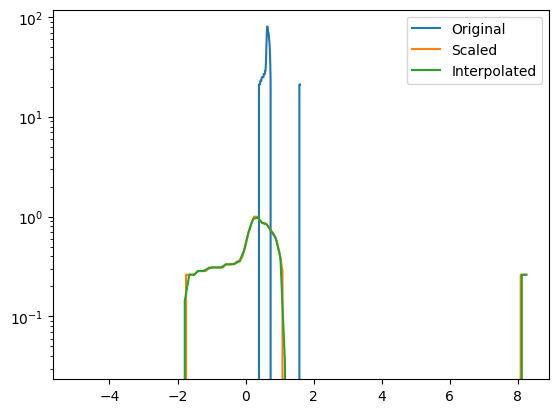

In [ ]:
# Example of 
y = data.scaled_stances_all_sensors_df['R8_stances'].iloc[0]
x = np.linspace (0,len(y)*0.01,len(y))
## Plot with log scale
plt.plot(x, y, label='Original')
plt.plot(data.scaled_stances_all_sensors_df['R8_stances_scaled_x'].iloc[0], data.scaled_stances_all_sensors_df['R8_stances_scaled_y'].iloc[0], label='Scaled')
plt.plot(data.scaled_stances_all_sensors_df['R8_stances_new_x'].iloc[0], data.scaled_stances_all_sensors_df['R8_stances_new_y'].iloc[0], label='Interpolated')
plt.yscale('log')
#plt.axvline(peak_pos, color='r', linestyle='--', label='Peak Position')
plt.legend()
plt.show()

In [ ]:
# example
d=data.return_array_df(data.scaled_right_stances,'new_y',['r_swings_time','max_peak','fwhm_value'])

In [ ]:
# example
d=data.return_array_df_mul_lists(data.scaled_stances_all_sensors_df,['R7_interp','R6_interp','R5_interp','R8_interp'],['r_max_peak','l_max_peak','l_total_fwhm'])